# Домашнее задание

В этом домашнем задании вам предстоит обучить модель классификации рукописных цифр на Tensorflow.

Важным дополнительным требованием будет сохранение чекпоинтов на ваш гугл диск (не переживайтеЖ ниже будут подсказки, как это сделать). Это пригодится вам в дальнейшем при обучении более сложных моделей, на случай потери данных при неожиданном отключении Colab.

In [27]:
import tensorflow as tf
print(tf.__version__)
from google.colab import drive
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

#tf.enable_eager_execution()

2.6.0


####Вспомогательный код

In [28]:
#@title 
def show_mnist(images, labels, predicted_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {labels[i]}. Pred: {predicted_labels[i]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {labels[i]}")

def show_progress(history: dict):
    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(1,2,1)    
    plt.plot(history["accuracy"],label='train accuracy')
    plt.plot(history["val_accuracy"], label='test accuracy')
    ax2 = plt.subplot(1,2,2)
    plt.plot(history["loss"],label='train_loss')
    plt.plot(history["val_loss"],label='test_loss')
    
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    plt.grid()
    plt.tight_layout()
    plt.show()

## Загрузка данных

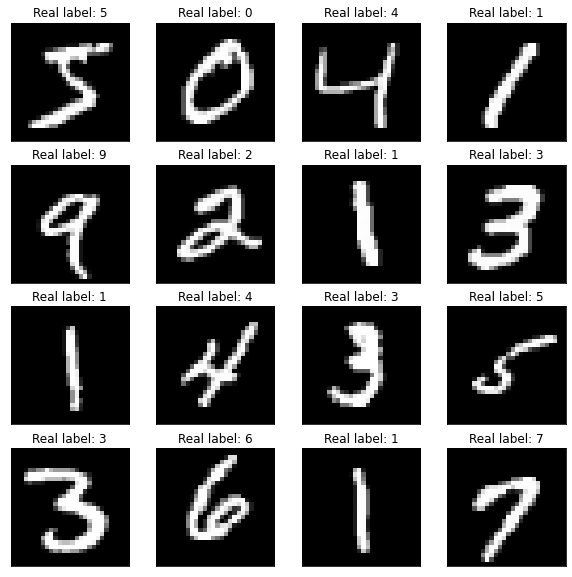

In [29]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

show_mnist(x_train, y_train)
x_train = x_train.reshape((-1, 28*28)) # вытянули каждую картинку в вектор
x_test = x_test.reshape((-1, 28*28))


In [30]:
# прикрепим ваш гугл диск к виртуальной машине
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [31]:
# Путь до вашего гугл диска скорее всего выглядит так: /content/drive/My Drive/
# если эта клетка вызывает ошибку, 
# измените путь согласно ! ls "/content/drive/"

path = Path("/content/drive/My Drive/Skillbox/model_1")
path.mkdir(exist_ok=True, parents=True) # папка создается на вашем гугл диске. вместе с "родителями"
assert path.exists()
cpt_filename = "best_checkpoint.hdf5"  
cpt_path =str(path / cpt_filename)
# После выполнения этой клетки, в вашем гугл диске должна создаться папка: Skillbox/model_1
# убедитесь в этом

А весь код ниже вы реализуете самостоятельно! Вы уже к этому готовы :)
Требования к модели:
1. Точность на тестовой части выборки >96%
2. Чекпоинт модели с лучшими параметрами должен быть сохранен у вас на гугл диске
3. Объект history, который получается из model.fit(...) должен содержать значения лосса и accuracy для трейна и теста

In [32]:
import keras
import keras.layers as L

model =  tf.keras.models.Sequential([
                                     tf.keras.layers.Flatten(input_shape=(784,)),
                                     tf.keras.layers.Dense(784, activation='relu'),
                                     tf.keras.layers.Dense(64, activation='relu'),
                                     tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train, 
          batch_size=128, epochs=5,
          callbacks=[keras.callbacks.ModelCheckpoint(filepath=cpt_path, monitor="val_accuracy", save_best_only=True)],
          validation_data=(x_test, y_test))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_14 (Dense)             (None, 10)                650       
Total params: 666,330
Trainable params: 666,330
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
469/469 [==============================] - 5s 11ms/step - loss: 0.2287 - accuracy: 0.9338 - val_loss: 0.1130 - val_accuracy: 0.9636
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0845 - accuracy: 0.9746 - va

In [33]:
assert len(list(path.glob("*"))) != 0, f"Checkpoint dir {path}"
assert "accuracy" in history.history, "History object must contain Accuracy. Please, retrain with this metric"
assert "val_accuracy" in history.history, "Please, provide validation_data in model.fit."
assert np.max(history.history["val_accuracy"]) > 0.95, "Validation accuracy must be more than 0.95"
# Для старой версии (tf.__version__ == 1.x) запустить aseert-ы ниже:
# assert "acc" in history.history, "History object must contain Accuracy. Please, retrain with this metric"
# assert "val_acc" in history.history, "Please, provide validation_data in model.fit."
# assert np.max(history.history["val_acc"]) > 0.95, "Validation accuracy must be more than 0.95"
print("Training tests passed")

Training tests passed


Давайте посмотрим на графики обучения:

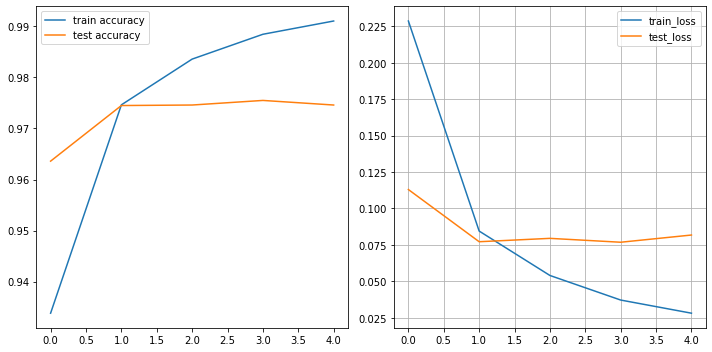

In [34]:
show_progress(history.history)

А теперь перейдем к загрузке модели. Если все реализовано правильно, то код ниже должен сработать без ошибок:

In [35]:
restored_model = tf.keras.models.load_model(cpt_path)
loss, acc = restored_model.evaluate(x_test, y_test)
print(f"Accuracy of restored model {acc*100 :.2f}%")
assert acc > 0.96

313/313 [==============================] - 1s 2ms/step - loss: 0.0768 - accuracy: 0.9755
Accuracy of restored model 97.55%


И, наконец, можно сравнить предсказания с реальными классами (с такой точностью найти ошибку будет сложно):

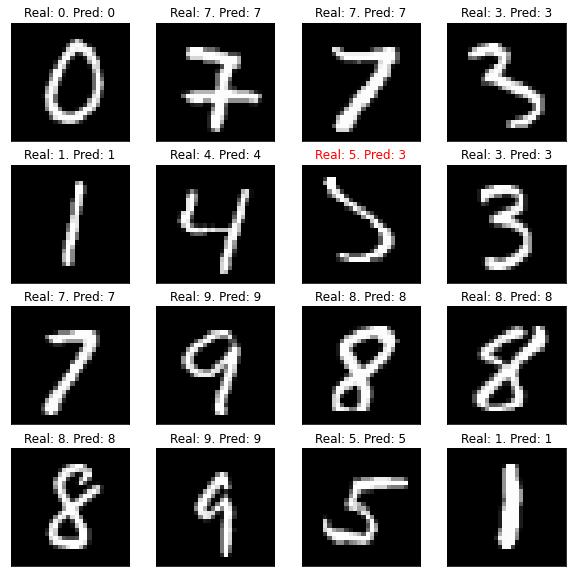

In [36]:
predicted_labels = np.argmax(restored_model.predict(x_test), axis=-1)
idxs = np.random.choice(np.arange(len(x_test)), 16, replace=False)
show_mnist(x_test[idxs].reshape((-1, 28, 28)), y_test[idxs], predicted_labels[idxs])

# Ускорение с помощью библиотеки TensorRT.|

In [37]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

In [38]:
model.save('saved_model')

INFO:tensorflow:Assets written to: saved_model/assets


In [39]:
converter = trt.TrtGraphConverterV2(input_saved_model_dir='saved_model')
converter.convert()
converter.save('saved_model_trt')

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Assets written to: saved_model_trt/assets


In [40]:
model_trt = tf.keras.models.load_model('saved_model_trt')

In [41]:
%%timeit -n 10 -r 10

q = model

10 loops, best of 10: 83.5 ns per loop


In [42]:
%%timeit -n 10 -r 10

q = model_trt

10 loops, best of 10: 70.8 ns per loop
